In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
import joblib
import re

# 载入数据
# data = pd.read_csv("E:\竞赛\服创赛-A08\data\特征集\output_file_2.csv") 
data = pd.read_csv("E:\\竞赛\\服创赛-A08\\data\\特征集\\new_features.csv")
data.shape

(16000, 380)

In [2]:
def check_column_names(df):
    # 正则表达式匹配字母、数字和下划线以外的字符
    pattern = '[^a-zA-Z0-9_\u4e00-\u9fff]'

    
    for col in df.columns:
        if re.search(pattern, col):
            print(f"列名 '{col}' 包含空格或其他特殊字符。")

# 检查列名
check_column_names(data)

列名 'Unnamed: 0' 包含空格或其他特殊字符。


In [3]:
delete_feature = ['Unnamed: 0','个人编码']

data = data.drop(delete_feature,axis=1)

In [4]:
# 在结尾处获取要删除的特征列表
# data = data.drop(columns=list(features_to_remove))
# data.head()

In [5]:
# 获取重要性最低的特征
# least_important_features = feature_importances_df.tail(1)

# # 删除这些特征
# data = data.drop(columns=least_important_features['Feature Name'])

In [6]:
# 分离特征和目标变量
X = data.drop('RES', axis=1)
y = data['RES']

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [7]:
class_counts = y_train.value_counts()
class_counts

RES
0    11405
1      595
Name: count, dtype: int64

In [8]:
# 计算类别权重
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weight_dict = {i : weights[i] for i in range(len(weights))}

# 应用Random Under Sampler
rus = RandomUnderSampler(random_state=42,sampling_strategy = {0: 595, 1: 595})
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)


X_train_rus.shape

(1190, 377)

In [9]:
# 创建随机森林分类器实例
rf = RandomForestClassifier(
    n_estimators=128,       # 树的数量
    # criterion='gini',       # 用于分裂的质量度量，也可以是 'entropy'
    max_depth=None,         # 树的最大深度
    # min_samples_split=2,    # 分裂内部节点所需的最少样本数
    # min_samples_leaf=1,     # 在叶节点处需要的最少样本数
    # min_weight_fraction_leaf=0.0, # 在所有叶子节点处的权重总和中的最小加权分数
    # max_features='sqrt',    # 寻找最佳分割时考虑的特征数量
    # max_leaf_nodes=None,    # 以最佳优先方式增长树时的最大叶子节点数
    # min_impurity_decrease=0.0,    # 如果节点分裂导致不纯度减少大于或等于此值，则分裂节点
    # bootstrap=True,         # 是否在构建树时使用bootstrap样本
    oob_score=False,        # 是否使用袋外样本来估计泛化精度
    n_jobs=-1,              # 拟合和预测时并行运行的作业数
    random_state=42,        # 控制组件的随机性
    verbose=0,              # 控制拟合和预测的冗长程度
    warm_start=True,       # 设置为True时，重用上一个调用的解决方案以适应并在集合中添加更多的估计器
    # class_weight=weight_dict,      # 类别的权重
    # ccp_alpha=0.0,          # 用于最小成本-复杂性剪枝的复杂性参数
    # max_samples=None        # 如果 bootstrap 为 True，从 X 抽取的样本数
)


# 训练模型
rf.fit(X_train_rus, y_train_rus)

# 预测
train_preds = rf.predict(X_train_rus)
test_preds = rf.predict(X_test)
train_proba = rf.predict_proba(X_train_rus)[:, 1]
test_proba = rf.predict_proba(X_test)[:, 1]

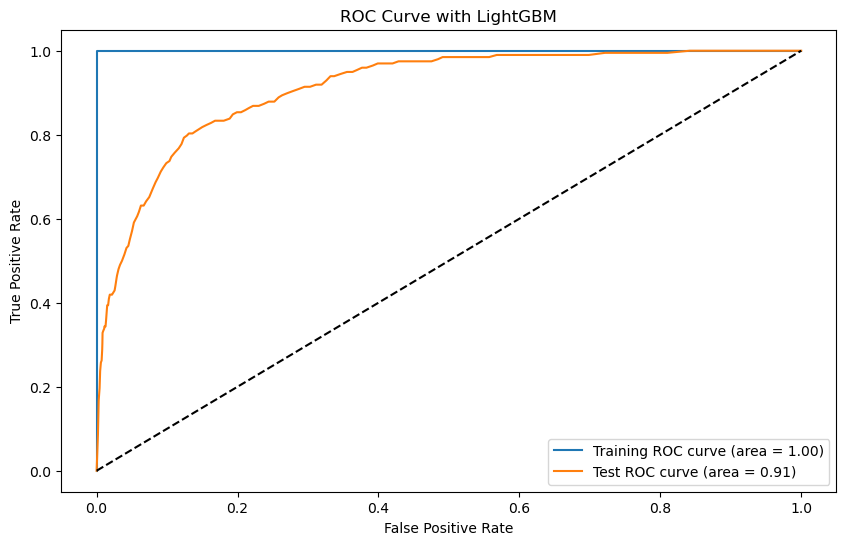

In [10]:
# 性能评估
train_classification_report = classification_report(y_train_rus, train_preds)
test_classification_report = classification_report(y_test, test_preds)
train_roc_auc = roc_auc_score(y_train_rus, train_proba)
test_roc_auc = roc_auc_score(y_test, test_proba)

# 绘制ROC曲线
fpr_train, tpr_train, _ = roc_curve(y_train_rus, train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, test_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f'Training ROC curve (area = {train_roc_auc:.2f})')
plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (area = {test_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with LightGBM')
plt.legend()
plt.show()

In [11]:
from sklearn.metrics import classification_report

# Calculate the classification reports
train_classification_report = classification_report(y_train_rus, train_preds)
test_classification_report = classification_report(y_test, test_preds)

# Print the classification reports
print("Training Set Classification Report:\n", train_classification_report)
print("\nTest Set Classification Report:\n", test_classification_report)

Training Set Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       595
           1       1.00      1.00      1.00       595

    accuracy                           1.00      1190
   macro avg       1.00      1.00      1.00      1190
weighted avg       1.00      1.00      1.00      1190


Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.81      0.89      3802
           1       0.19      0.84      0.31       198

    accuracy                           0.81      4000
   macro avg       0.59      0.82      0.60      4000
weighted avg       0.95      0.81      0.86      4000



In [12]:
# 设置阈值
threshold = 0.6

# 以概率形式获取预测结果
y_probs = rf.predict_proba(X_test)[:, 1] # 获取正类的概率

# 应用阈值
y_pred_thresh = np.where(y_probs > threshold, 1, 0)

# 生成分类报告
classification_report_06 = classification_report(y_test, y_pred_thresh)

print(classification_report_06)

              precision    recall  f1-score   support

           0       0.99      0.88      0.93      3802
           1       0.25      0.78      0.38       198

    accuracy                           0.87      4000
   macro avg       0.62      0.83      0.66      4000
weighted avg       0.95      0.87      0.90      4000



In [13]:
auc_score = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])

print("Test AUC Score:", auc_score)
X_train_rus.shape

Test AUC Score: 0.9116174899972901


(1190, 377)

In [14]:
# import joblib

# # 保存模型和特征
# model_features = {
#     'model': rf,
#     'features': X_train.columns.tolist()
# }
# joblib.dump(model_features, 'E:\竞赛\服创赛-A08\\model\\rf\\rf_model_6_0.91737.pkl')

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
rc = {'font.sans-serif': 'SimHei',
      'axes.unicode_minus': False}
sns.set(context='notebook', style='ticks', rc=rc)


from sklearn.feature_selection import mutual_info_classif
%matplotlib inline
pd.set_option("display.max_columns",100)
pd.set_option('display.max_rows',100)

from pylab import mpl 
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False  # 为了显示负号正常

import warnings
warnings.filterwarnings("ignore")

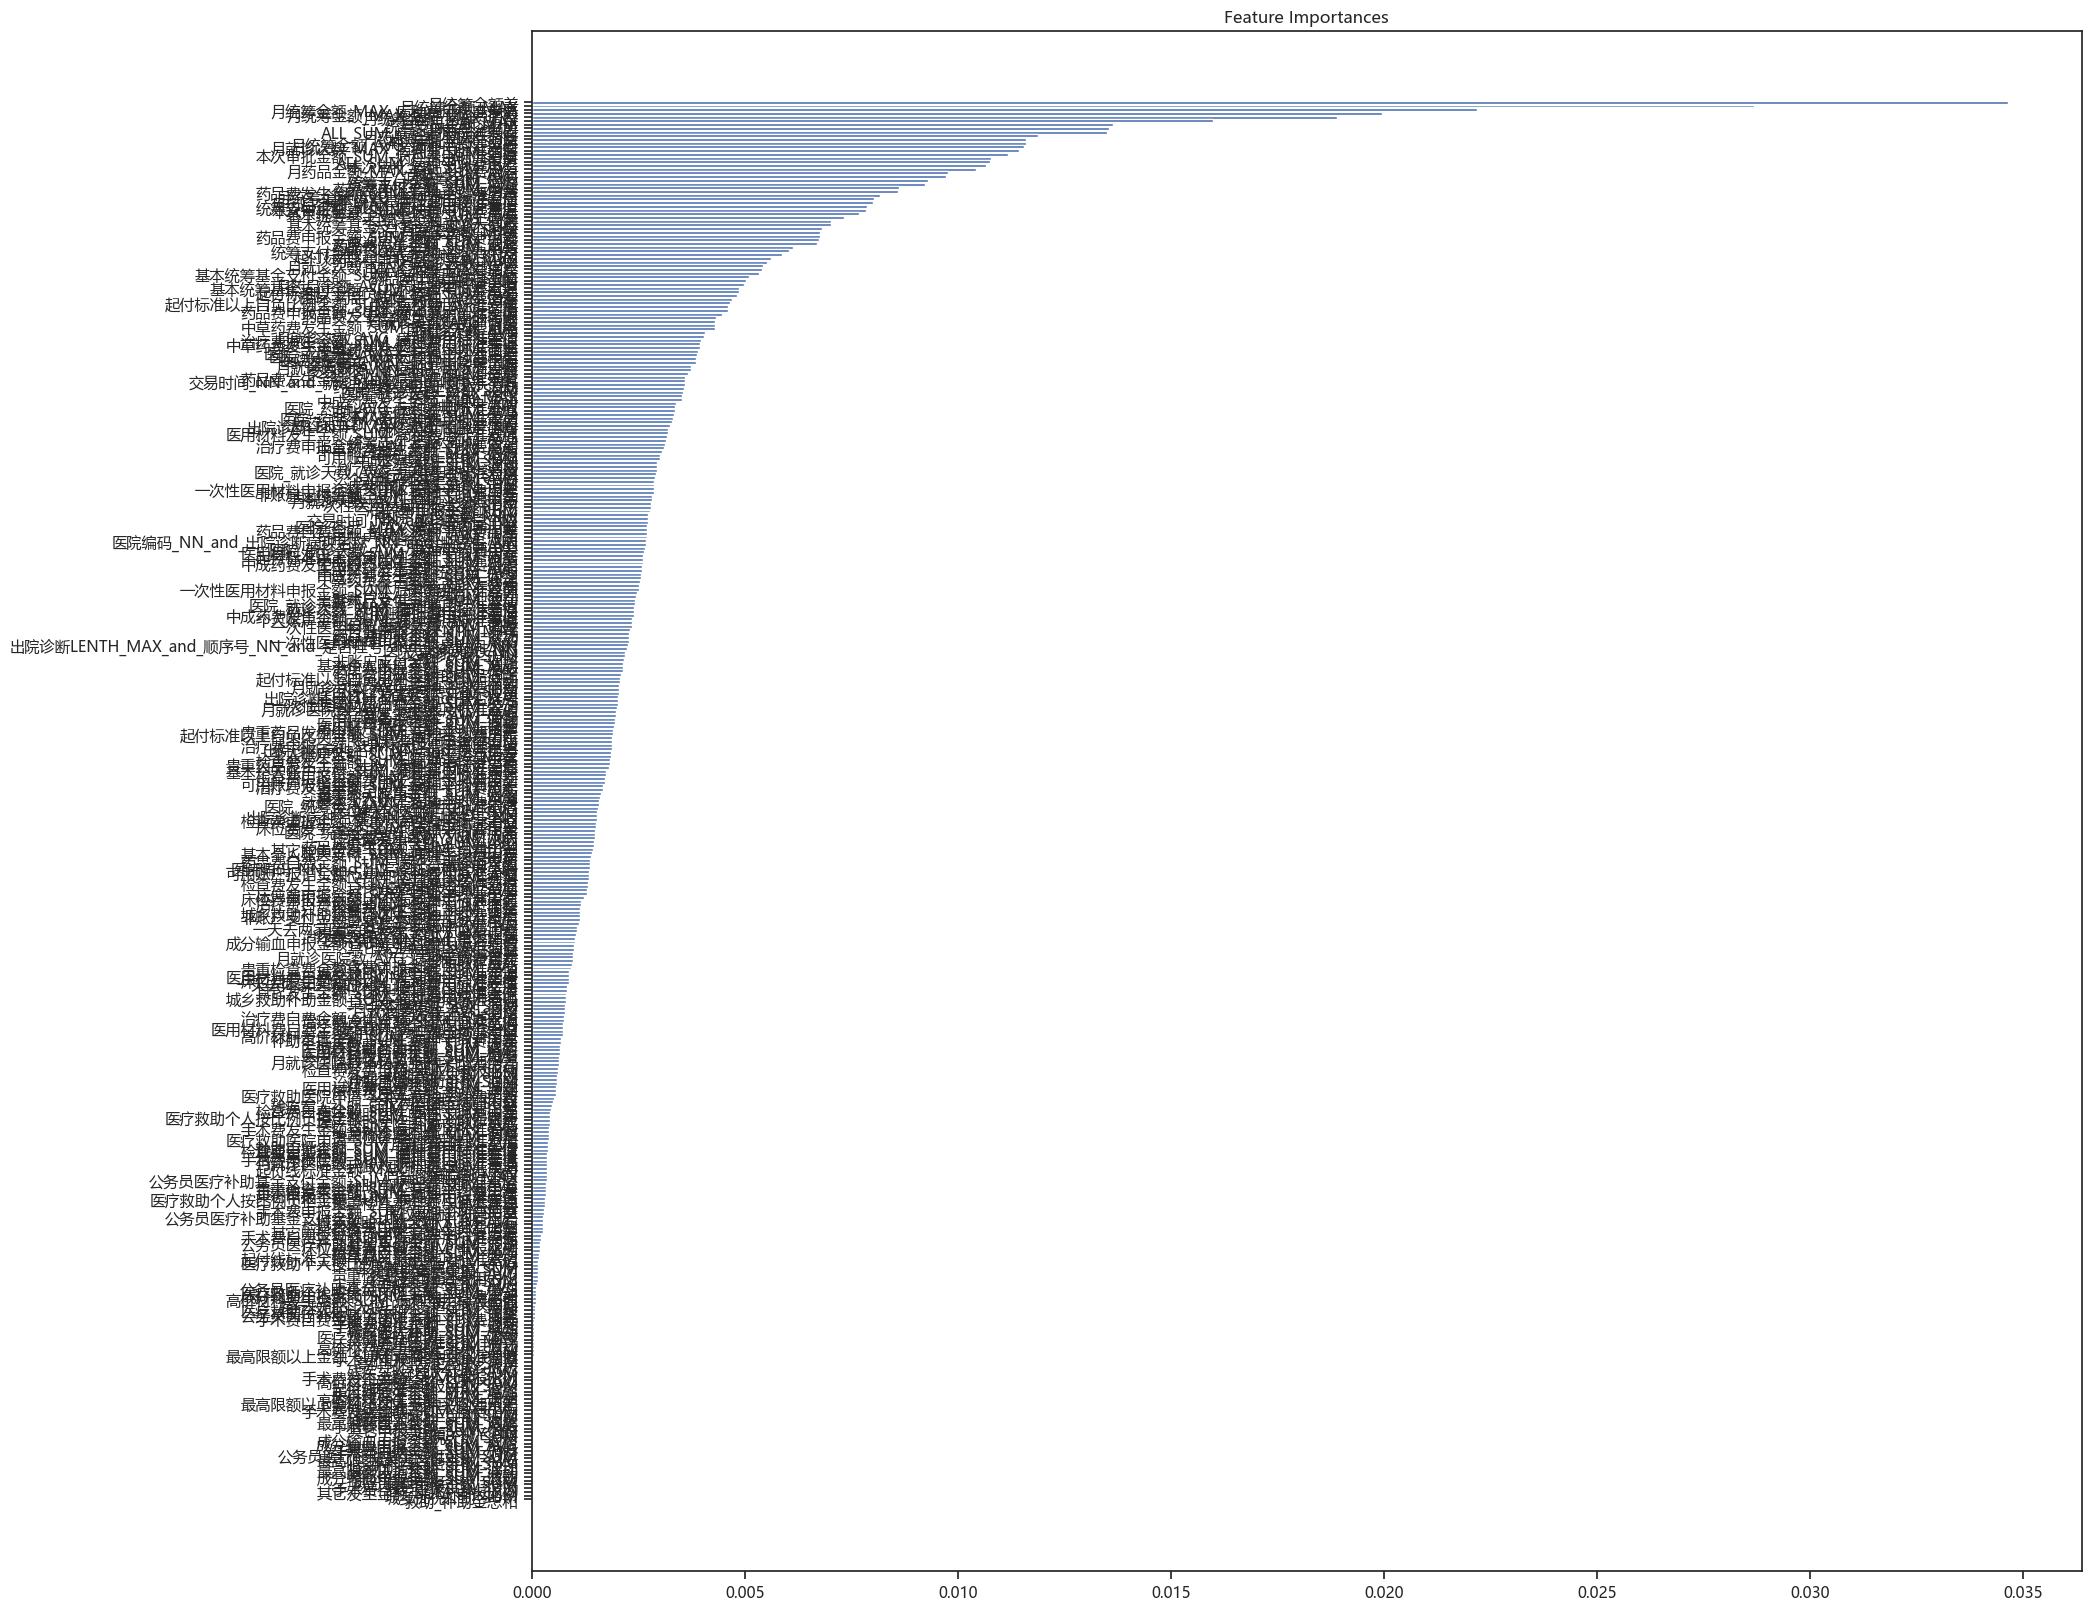

In [16]:
# 获取特征重要性
feature_importance = rf.feature_importances_

# 转换为Pandas DataFrame
feature_names = X_train.columns
feature_importances_df = pd.DataFrame({'Feature Name': feature_names, 'Importance': feature_importance})

# 对特征重要性进行排序
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# 可视化特征重要性
plt.figure(figsize=(100, 20))
plt.title('Feature Importances')
plt.barh(feature_importances_df['Feature Name'], feature_importances_df['Importance'])
plt.gca().invert_yaxis()
plt.show()

In [17]:
feature_importances_df

,Feature Name,Importance
151,月统筹金额差,0.034641
9,月统筹金额_MAX,0.028689
220,月统筹金额_MAX_病种费用标准差值,0.022191
323,月统筹金额_MAX_病种平均费用差,0.019959
162,月统筹金额_MAX_调整,0.018905
...,...,...
52,其它申报金额_SUM,0.000000
123,手术费自费金额_SUM_波动,0.000000
104,其它发生金额_SUM_申报比例,0.000000
68,城乡优抚补助_SUM,0.000000


In [18]:
high_corr_pairs = []
correlation_matrix = data.corr()
for col in correlation_matrix.columns:
    for row in correlation_matrix.index:
        if (correlation_matrix.loc[row, col] > 0.9) and (col != row):
            # Check if the pair is already added
            if not {(row, col), (col, row)}.intersection(set(high_corr_pairs)):
                high_corr_pairs.append((row, col))

high_corr_pairs

[('一天去两家医院的天数_病种费用标准差值', '一天去两家医院的天数'),
 ('交易时间YYYYMM_NN', '就诊的月数'),
 ('月就诊天数_AVG', '月就诊天数_MAX'),
 ('就诊次数_SUM', '月就诊天数_MAX'),
 ('月就诊次数_MAX', '月就诊天数_MAX'),
 ('月就诊次数_AVG', '月就诊天数_MAX'),
 ('交易时间DD_NN', '月就诊天数_MAX'),
 ('月就诊天数_AVG_调整', '月就诊天数_MAX'),
 ('就诊次数_SUM_调整', '月就诊天数_MAX'),
 ('月就诊次数_MAX_调整', '月就诊天数_MAX'),
 ('月就诊次数_AVG_调整', '月就诊天数_MAX'),
 ('月就诊天数_AVG_病种费用标准差值', '月就诊天数_MAX'),
 ('就诊次数_SUM_病种费用标准差值', '月就诊天数_MAX'),
 ('月就诊次数_MAX_病种费用标准差值', '月就诊天数_MAX'),
 ('月就诊次数_AVG_病种费用标准差值', '月就诊天数_MAX'),
 ('就诊次数_SUM', '月就诊天数_AVG'),
 ('月就诊次数_MAX', '月就诊天数_AVG'),
 ('月就诊次数_AVG', '月就诊天数_AVG'),
 ('交易时间DD_NN', '月就诊天数_AVG'),
 ('月就诊天数_AVG_调整', '月就诊天数_AVG'),
 ('就诊次数_SUM_调整', '月就诊天数_AVG'),
 ('月就诊次数_MAX_调整', '月就诊天数_AVG'),
 ('月就诊次数_AVG_调整', '月就诊天数_AVG'),
 ('月就诊天数_AVG_病种费用标准差值', '月就诊天数_AVG'),
 ('就诊次数_SUM_病种费用标准差值', '月就诊天数_AVG'),
 ('月就诊次数_MAX_病种费用标准差值', '月就诊天数_AVG'),
 ('月就诊次数_AVG_病种费用标准差值', '月就诊天数_AVG'),
 ('月就诊天数_AVG_病种平均费用差', '月就诊天数_AVG'),
 ('就诊次数_SUM_病种平均费用差', '月就诊天数_AVG'),
 ('月就诊次数_AVG_病种平均费用差', '月就诊天数_AVG'),
 ('月就诊

In [19]:
# 初始化要删除的特征列表
# 特征a与特征b高度相关，但是特征a的特征重要性大于b，那么就删除特征b
features_to_remove = set()

for feature1, feature2 in high_corr_pairs:
    # 获取两个特征的重要性
    importance_feature1 = feature_importances_df[feature_importances_df['Feature Name'] == feature1]['Importance'].values[0]
    importance_feature2 = feature_importances_df[feature_importances_df['Feature Name'] == feature2]['Importance'].values[0]

    # 比较重要性并添加较低的一个到删除列表
    if importance_feature1 > importance_feature2:
        features_to_remove.add(feature2)
    else:
        features_to_remove.add(feature1)

# 输出要删除的特征列表
features_to_remove

{'ALL_SUM',
 'ALL_SUM_AVG',
 'ALL_SUM_波动',
 'ALL_SUM_病种平均费用差',
 'ALL_SUM_病种费用标准差值',
 'ALL_SUM_调整',
 '一天去两家医院的天数',
 '一天去两家医院的天数_病种费用标准差值',
 '一次性医用材料申报金额_SUM',
 '一次性医用材料申报金额_SUM_AVG',
 '一次性医用材料申报金额_SUM_波动',
 '一次性医用材料申报金额_SUM_病种平均费用差',
 '一次性医用材料申报金额_SUM_病种费用标准差值',
 '一次性医用材料申报金额_SUM_调整',
 '个人支付检查费用占比',
 '个人账户金额_SUM',
 '个人账户金额_SUM_AVG',
 '个人账户金额_SUM_波动',
 '个人账户金额_SUM_病种平均费用差',
 '个人账户金额_SUM_病种费用标准差值',
 '中成药费发生金额_SUM_AVG',
 '中成药费发生金额_SUM_病种平均费用差',
 '中成药费发生金额_SUM_病种费用标准差值',
 '中成药费发生金额_SUM_调整',
 '中草药费发生金额_SUM',
 '中草药费发生金额_SUM_AVG',
 '中草药费发生金额_SUM_病种费用标准差值',
 '中草药费发生金额_SUM_调整',
 '交易时间DD_NN',
 '交易时间_NN_and_顺序号_NN',
 '公务员医疗补助基金支付金额_SUM',
 '公务员医疗补助基金支付金额_SUM_AVG',
 '公务员医疗补助基金支付金额_SUM_病种平均费用差',
 '公务员医疗补助基金支付金额_SUM_调整',
 '其它发生金额_SUM',
 '其它发生金额_SUM_AVG',
 '其它发生金额_SUM_调整',
 '其它申报金额_SUM',
 '其它申报金额_SUM_AVG',
 '其它申报金额_SUM_波动',
 '其它申报金额_SUM_调整',
 '出院诊断LENTH_MAX_and_是否挂号',
 '出院诊断LENTH_MAX_and_顺序号_NN_and_是否挂号_and_交易时间_NN',
 '出院诊断病种名称_NN_and_顺序号_NN',
 '医用材料发生金额_SUM',
 '医用材料发生金额_SUM_AVG',
 '医用材料发生金额_SUM_病种平均费用